# Summary

In the first stage, we established that selecting a simple portfolio built with classical methods is more reliable than attempting to select or compose a portfolio using machine learning, in particular neural networks.

During the second stage, we wanted to establish whether adding more relevant features to the training data and reducing the problem to a simple forecast (of future covariance or future returns) is a viable strategy. If this does not improve the base model, it will confirm our hypothesis that portfolio allocation should be performed based on fundamentals of portfolio theory and economics, rather than based on advanced analytics and forecasting.

This summary consists of following parts:
1. Base model performance testing (classical portfolio theory)
2. Training advanced forecasting model
  - dataset assembly
  - model architecture definition
  - training & validation of created model
3. Building hybrid portfolios
4. Comparison of test results between portfolio strategies

## Base model performance

In [49]:
import pandas as pd
import numpy as np
pd.set_option('precision', 4)
pd.set_option('chop_threshold', 1e-15)

from numba import jit

from typing import Tuple

from utils.data_loader import *

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [50]:
class OneYearTest(object):
    """
    Scikit-learn style iterator returning training- and test-set indices,
    where test set is one-year-long and training set consists of n_train_years
    preceding the test set year.
    """
    def __init__(self, df: pd.DataFrame, n_train_years: int=10):
        self.index_years = df.index.year
        self.unique_years = np.unique(self.index_years)
        self.n_train_years = n_train_years
        
    @property
    def train_years(self):
        return set(self.unique_years[self.idx-self.n_train_years:self.idx])
    
    @property
    def test_year(self):
        return self.unique_years[self.idx]

    def __iter__(self):
        self.idx = self.n_train_years
        return self
    
    def __next__(self):
        if self.idx < len(self.unique_years):
            train_ids = self.index_years.isin(self.train_years)
            test_ids = self.index_years == self.test_year
            self.idx += 1
            return train_ids, test_ids
        else:
            raise StopIteration

In [51]:
@jit(nopython=True)
def portfolio_performance(allocation: np.array, fund_values: np.array) -> Tuple[float, float]:
    """
    Calculates total returns and daily returns volatility during entire period of provided fund values.
    """
    allocation = allocation / np.sum(allocation)  # normalize the weights to make sure they sum up to 1
    period_returns = (fund_values[-1] - fund_values[0]) / fund_values[0]
    daily_returns = (fund_values[1:] - fund_values[:-1]) / fund_values[:-1]
    portfolio_period_returns = np.sum(allocation * period_returns)
    portfolio_daily_returns = np.sum(allocation * daily_returns, axis=1)
    portfolio_period_volatility = np.sqrt(
        np.sum((portfolio_daily_returns - np.mean(portfolio_daily_returns))**2)
    )  # volatility using same formula as in SRRI paper
    return portfolio_period_returns, portfolio_period_volatility

In [52]:
@jit(nopython=True)
def historical_volatility(allocation: np.array, fund_values: np.array) -> int:
    """
    Calculates SRRI based on porfolio volatility 
    during last 5 years of provided fund_values,
    as described in https://bit.ly/2RDVib9
    """
    m = 260  # days in a year, as in the SRRI paper
    T = 5*260  # days in 5 years, as in the SRRI paper
    allocation = allocation / np.sum(allocation)  # normalize the weights to make sure they sum up to 1
    fund_values = fund_values[-T:]  # reduce time interval to last 5 years
    daily_returns = (fund_values[1:] - fund_values[:-1]) / fund_values[:-1]
    portfolio_daily_returns = np.sum(allocation * daily_returns, axis=1)
    scaled_volatility = np.sqrt(m * np.sum((portfolio_daily_returns - np.mean(portfolio_daily_returns))**2) / (T-1))
    return scaled_volatility

@jit(nopython=True)
def srri(scaled_historical_volatility: float) -> int:
    if scaled_historical_volatility >= 0.25:
        return 7
    elif scaled_historical_volatility >= 0.15:
        return 6
    elif scaled_historical_volatility >= 0.1:
        return 5
    elif scaled_historical_volatility >= 0.05:
        return 4
    elif scaled_historical_volatility >= 0.02:
        return 3
    elif scaled_historical_volatility >= 0.005:
        return 2
    else:
        return 1

In [53]:
def base_model(funds_df: pd.DataFrame) -> np.array:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_return(0.04)
    return ef.weights

### Loading data

In [54]:
funds_df = load_funds()
funds_df.head()

,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,
2000-01-03,415.90,549.11,354.45,401.26,275.08,520.13,230.72
2000-01-04,404.41,533.89,357.14,401.42,275.08,520.02,229.63
2000-01-05,400.04,527.38,351.19,401.59,275.08,519.22,229.22
2000-01-06,410.15,522.02,347.96,401.75,275.07,519.62,228.82
2000-01-07,429.16,533.16,351.87,401.93,275.07,520.80,230.09


### Evaluating model performance

In [55]:
result_dfs = []
for train_ids, test_ids in OneYearTest(funds_df):
    train_, test_ = funds_df[train_ids], funds_df[test_ids]
    allocation = base_model(train_)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    hist_vol = historical_volatility(allocation, train_.values)
    hist_srri = srri(hist_vol)
    returns, volatility = portfolio_performance(allocation, test_.values)
    performance_data = {
        'srri': hist_srri, 
        'volatility': hist_vol,
        'test_year_returns': returns, 
        'test_year_volatility': volatility
    }
    result_dfs.append(
        pd.DataFrame({**allocation_data, **performance_data}, index=[test_.index.year[0]])
    )
base_results_df = pd.concat(result_dfs, axis='index')
base_results_df

,AP,ARR,ARW,G,OP,ORR,ORW,srri,volatility,test_year_returns,test_year_volatility
2010,0.0000e+00,0.0972,0.0000e+00,0.0300,0.0000e+00,0.8728,0.0000e+00,3,0.0255,0.0411,0.0218
2011,0.0000e+00,0.0726,0.0000e+00,0.1379,0.0000e+00,0.7895,0.0000e+00,3,0.0226,0.0474,0.0173
2012,0.0000e+00,0.0299,0.0000e+00,0.1635,0.0000e+00,0.8065,0.0000e+00,3,0.0230,0.0398,0.0158
2013,0.0000e+00,0.0000,0.0000e+00,0.3964,9.8262e-02,0.5053,0.0000e+00,2,0.0158,0.0073,0.0150
2014,0.0000e+00,0.0120,0.0000e+00,0.3697,1.7110e-01,0.4390,8.2929e-03,2,0.0135,0.0588,0.0115
2015,0.0000e+00,0.0476,0.0000e+00,0.4063,1.3233e-01,0.4121,1.7235e-03,2,0.0116,0.0065,0.0169
2016,0.0000e+00,0.0074,0.0000e+00,0.3376,2.0575e-01,0.3393,1.0993e-01,2,0.0155,0.0215,0.0179
2017,0.0000e+00,0.0000,0.0000e+00,0.3130,2.3905e-01,0.3097,1.3827e-01,2,0.0177,0.0296,0.0127
2018,0.0000e+00,0.0048,0.0000e+00,0.3070,2.3387e-01,0.3055,1.4884e-01,2,0.0180,0.0083,0.0123


## Advanced model performance

We will attempt to train a deep neural network, that will attempt to predict future returns as well as future fund value covariance.

In [56]:
from dataclasses import dataclass, asdict
import multiprocessing as mp

from tqdm import tqdm

import ta

### External data

In the first stage of competitions, we downloaded a lot of seemingly useful data, but its volume was too large 
for any meaningful feature selection to be performed.

This time, we have carefully selected by hand the most important indices that may play a role in terms of forecasting
portfolio performance.

The data was manually downloaded from [Stooq](https://stooq.pl/).

In [57]:
external_data = load_stooq()

### Feature generation

For our fund values and index values downloaded above, we will calculate similar features to the ones mentioned by: 
*Bao, W., Yue, J., Rao, Y. (2017). A deep learning framework for financial time series
using stacked autoencoders and long-short term memory.*

Note, that most of the technical indicators can only be calculated for the downloaded index values,
as our fund values do not have open-high-low-close price & volume information attached to it.

In [58]:
fund_column_features = {
    'MACD': lambda col: ta.trend.macd(col, n_fast=80, n_slow=160),
    'BBL': lambda col: ta.volatility.bollinger_lband(col, n=120),
    'BBH': lambda col: ta.volatility.bollinger_hband(col, n=120),
    'EMA': lambda col: ta.trend.ema_indicator(col, n=240),
    'ID': lambda col: col
}

ohlc_df_features = {
    'MACD': lambda df: ta.trend.macd(df['Zamkniecie'], n_fast=80, n_slow=160),
    'BBL': lambda df: ta.volatility.bollinger_lband(df['Zamkniecie'], n=120),
    'BBH': lambda df: ta.volatility.bollinger_hband(df['Zamkniecie'], n=120),
    'EMA': lambda df: ta.trend.ema_indicator(df['Zamkniecie'], n=240),
    'SMI': lambda df: ta.momentum.stoch(
        high=df['Najwyzszy'],
        low=df['Najnizszy'],
        close=df['Zamkniecie'],
        n=160
    ),
    'ID': lambda df: df['Zamkniecie']
}

ohlc_volume_df_features = {
    'MFI': lambda df: ta.momentum.money_flow_index(
        high=df['Najwyzszy'],
        low=df['Najnizszy'],
        close=df['Zamkniecie'],
        volume=df['Wolumen'].fillna(df['Wolumen'].mean()),  # volumes often have missing values in our dataset
        n=120
    ),
    # this is always appended with ohlc_df_features => no 'ID' ("identity") feature is necessary
}

In [59]:
OHLC_COLUMNS = ['Otwarcie', 'Zamkniecie', 'Najwyzszy', 'Najnizszy']

features_df = pd.DataFrame(index=funds_df.index)
for col in tqdm(funds_df.columns, desc='Funds'):
    for key in fund_column_features:
        features_df[f'{col}_{key}'] = fund_column_features[key](funds_df[col])
        
for ext_df, idx_name in tqdm(external_data, desc='External data'):
    ext_df = ext_df.reindex(index=funds_df.index)
    # we forward-fill missing values to account for differences between trading days across the world
    ext_df[OHLC_COLUMNS] = ext_df[OHLC_COLUMNS].fillna(method='ffill')
    for key in ohlc_df_features:
        if '3m' in idx_name and key not in {'MACD', 'EMA', 'ID'}:
            # for central bank interest rates, only calculate these 3 features
            continue
        features_df[f'{idx_name}_{key}'] = ohlc_df_features[key](
            ext_df.fillna(method='ffill')
        )
    if 'Wolumen' in ext_df.columns:
        for key in ohlc_volume_df_features:
            features_df[f'{idx_name}_{key}'] = ohlc_volume_df_features[key](ext_df)
print(features_df.shape)

External data: 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]

(4801, 77)


### Target generation

In [60]:
@dataclass
class Target(object):
    fund_returns: np.array
    fund_covariance: np.array
    ideal_allocation: np.array
    ideal_returns: float

In [61]:
def calculate_target(funds_df: pd.DataFrame) -> Target:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.1)
    ideal_allocation = ef.weights
    ideal_returns = ef.portfolio_performance()[0]
    return Target(mu, S, ideal_allocation, ideal_returns)

We calculate all target data in parallel to save time:

In [62]:
%%time
YEAR_DAYS = 260

dfs = [
    funds_df[idx+1 : idx+1+YEAR_DAYS]
    for idx in range(funds_df.iloc[:-YEAR_DAYS].shape[0])
]
with mp.Pool(processes=12) as pool:
    targets = pool.map(calculate_target, dfs)

print(len(targets))

4541
CPU times: user 5.37 s, sys: 316 ms, total: 5.69 s
Wall time: 27.3 s


Then, we extract information necessary for our experiment and back it up:

In [63]:
returns_target = np.zeros_like(funds_df[:-YEAR_DAYS])
covariance_target = np.zeros(
    (len(funds_df[:-YEAR_DAYS]), funds_df.shape[1]**2)
)
sample_weights = np.zeros(len(funds_df[:-YEAR_DAYS]))

for idx, target in enumerate(targets):
    returns_target[idx] = target.fund_returns.values.ravel()
    covariance_target[idx] = target.fund_covariance.values.ravel()
    sample_weights[idx] = target.ideal_returns  # years with higher returns are more important

np.save('data/forecasting/returns_target.npy', returns_target)
np.save('data/forecasting/covariance_target.npy', covariance_target)
np.save('data/forecasting/sample_weights.npy', sample_weights)

We can also add past targets to our features:

In [64]:
returns_features = np.zeros_like(funds_df)
returns_features[:YEAR_DAYS] = np.nan
returns_features[YEAR_DAYS:] = returns_target

covariance_features = np.zeros(
    (len(funds_df), funds_df.shape[1]**2)
)
covariance_features[:YEAR_DAYS] = np.nan
covariance_features[YEAR_DAYS:] = covariance_target

weights_features = np.zeros(len(funds_df))
weights_features[:YEAR_DAYS] = np.nan
weights_features[YEAR_DAYS:] = sample_weights

### Model definition

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

assert(torch.cuda.is_available())
cuda_device = 0
torch.cuda.empty_cache()

In [66]:
class LSTM(nn.Module):
    """
    Most basic LSTM regression model.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2, cuda_device=cuda_device):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.cuda_device = cuda_device

        self.lstm = nn.LSTM(
            self.input_dim, 
            self.hidden_dim, 
            self.num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32)
        )
        return self.hidden

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input)
        # shape of lstm_out: [batch_size, seq_len, hidden_dim]
        y_pred = self.linear(lstm_out[:,-1].view(self.batch_size, -1))
        return y_pred.view(-1)

### Training & evaluation

In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [68]:
all_features = np.hstack([features_df.values, returns_features, covariance_features, weights_features.reshape(-1, 1)])
features_valid = np.all(~np.isnan(all_features), axis=1)
feature_scaler = MinMaxScaler()
all_features[features_valid] = feature_scaler.fit_transform(all_features[features_valid])

all_targets = np.hstack([returns_target, covariance_target])
targets_valid = np.all(~np.isnan(all_targets), axis=1)
target_scaler = StandardScaler()
all_targets[targets_valid] = target_scaler.fit_transform(all_targets[targets_valid])

# unlike features, targets are only generated when they are valid
assert(sum(targets_valid) == len(targets_valid))
assert(len(targets_valid) < len(features_valid))

# this is created for one-year-validation to have a correct index for data splitting
meta_df = pd.DataFrame(columns=['features_valid', 'target_valid'], index=funds_df.index)
meta_df['features_valid'].iloc[:len(features_valid)] = features_valid
meta_df['target_valid'].iloc[:len(targets_valid)] = targets_valid
meta_df.fillna(False, inplace=True)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [69]:
all_features.shape, all_targets.shape

((4801, 134), (4541, 56))

In [70]:
def as_sequences(
        X: np.array, 
        y: np.array, 
        seq_len: int, 
        batch_size: int, 
        cuda_device: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Allocates GPU memory for features and labels, 
    making sure they are in correct shape for LSTM:
    X: (n_batches, batch_size, sequence_length, n_features)
    y: (n_batches, batch_size, n_targets)
    """
    assert(len(X) == len(y))
    
    n_samples, n_features = X.shape
    n_targets = y.shape[1]
    n_batches = (n_samples-seq_len) // batch_size
    X_seqs = np.zeros((n_batches, batch_size, seq_len, n_features))
    y_labels = np.zeros((n_batches, batch_size, n_targets))
    for batch_idx in range(n_batches):
        X_seqs[batch_idx] = np.reshape(
            np.array([X[idx:idx+seq_len] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, seq_len, n_features)
        )
        y_labels[batch_idx] = np.reshape(
            np.array([y[idx+seq_len-1] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, n_targets)
        )
    return torch.from_numpy(X_seqs).to(cuda_device).type(torch.float32), torch.from_numpy(y_labels).to(cuda_device).type(torch.float32)

#### Training parameters

In [71]:
import matplotlib.pyplot as plt

In [72]:
n_epochs = 10
lr = 0.0002
model_hidden_dim = 80
seq_len = 2*YEAR_DAYS
val_set_len = YEAR_DAYS
batch_size = 1  # WARNING: Other sizes may not work right now

In [73]:
def train(model, X_train_, y_train_, X_valid_, y_valid_, n_epochs: int=n_epochs):
    model.to(cuda_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.MSELoss()
    train_loss_vals = np.zeros(n_epochs)
    eval_loss_vals = np.zeros(n_epochs)
    model_states = []
    for ep_idx in range(n_epochs):
        model.train()
        model.init_hidden()
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_train_, y_train_)), 
                total=len(X_train_), 
                desc=f'Training epoch={ep_idx+1}/{n_epochs}'):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss_val = loss(y_pred, y_batch)
            train_loss_vals[ep_idx] += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_loss_vals[ep_idx] = train_loss_vals[ep_idx] / len(X_train_)  # average training loss
        model.eval()
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_valid_, y_valid_)), 
                total=len(X_valid_), 
                desc=f'Validating epoch={ep_idx+1}/{n_epochs}'):
            with torch.no_grad():
                y_pred = model(X_batch)
                loss_val = loss(y_pred, y_batch)
                eval_loss_vals[ep_idx] += loss_val.item()
        eval_loss_vals[ep_idx] = eval_loss_vals[ep_idx] / len(X_valid_)  # average validation loss
        model_states.append(model.state_dict())  # save model state
    # return model with the best state, ready for evaluation or inference
    model.load_state_dict(model_states[np.argmin(eval_loss_vals)])
    model.eval()
    return model, train_loss_vals, eval_loss_vals

In [74]:
def predict_allocate(model, X, transformer, n_funds=7):
    with torch.no_grad():
        # reshape preserves dimensions when batch_size=1
        y_pred = model(X).reshape(len(X), -1).cpu().numpy()
    y_last_pred = transformer.inverse_transform(y_pred[-1])
    mu = y_last_pred[:n_funds]
    S = y_last_pred[n_funds:].reshape((n_funds, n_funds))
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.1)  # 10% max volatility target
    # normalizing output in case scaling and 32bit casts for GPU
    # altered it resulting in allocation of more than 100% of portfolio
    weights = ef.weights
    return weights / np.sum(weights)

Skipping iteration with test_year=2010 due to lack of valid features in training set:
Valid features: 2270, required: 2530
Skipping iteration with test_year=2011 due to lack of valid features in training set:
Valid features: 2525, required: 2533


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 81.44it/s]


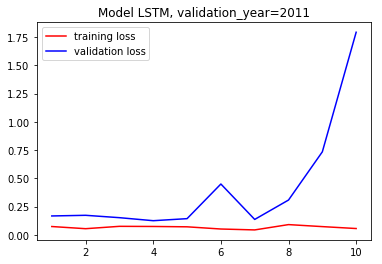

          AP  ARR         ARW       G      OP     ORR     ORW  srri  \
2012  0.0052  0.0  2.1079e-15  0.1717  0.1684  0.1971  0.4577     3   

      volatility  test_year_returns  test_year_volatility  
2012      0.0371             0.1152                0.0167  


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 81.73it/s]


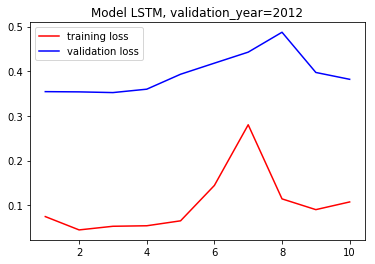

       AP  ARR  ARW       G      OP     ORR     ORW  srri  volatility  \
2013  0.0  0.0  0.0  0.3767  0.2231  0.1605  0.2397     3      0.0221   

      test_year_returns  test_year_volatility  
2013            -0.0035                0.0242  


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 82.35it/s]


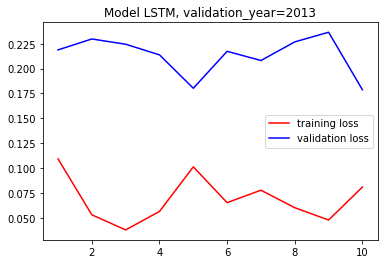

          AP     ARR         ARW       G      OP  ORR         ORW  srri  \
2014  0.0535  0.2654  0.0000e+00  0.4398  0.2413  0.0  0.0000e+00     4   

      volatility  test_year_returns  test_year_volatility  
2014      0.0556             0.0446                0.0277  


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 81.93it/s]


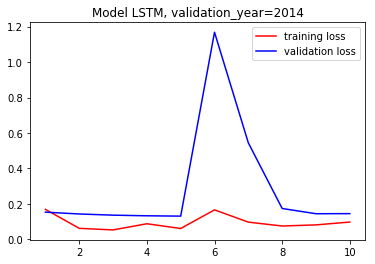

              AP     ARR  ARW    G      OP     ORR     ORW  srri  volatility  \
2015  0.0000e+00  0.1224  0.0  0.0  0.4044  0.4257  0.0475     3       0.024   

      test_year_returns  test_year_volatility  
2015             0.0037                 0.029  


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 82.39it/s]


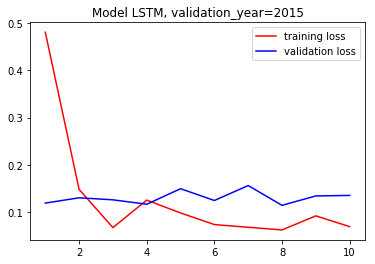

       AP  ARR  ARW           G          OP  ORR         ORW  srri  \
2016  0.0  0.0  0.0  2.1111e-15  1.4941e-15  1.0  0.0000e+00     3   

      volatility  test_year_returns  test_year_volatility  
2016       0.027             0.0222                0.0331  


Validating epoch=10/10: 100%|██████████| 259/259 [00:03<00:00, 82.57it/s]


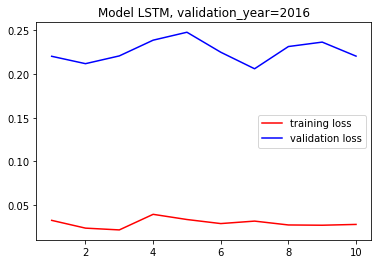

       AP  ARR  ARW           G   OP     ORR     ORW  srri  volatility  \
2017  0.0  0.0  0.0  0.0000e+00  0.0  0.2036  0.7964     3      0.0399   

      test_year_returns  test_year_volatility  
2017             0.0789                0.0249  
Skipping iteration with test_year=2018 due to lack of valid targets in training set:
Valid targets: 2520, required: 2528


,AP,ARR,ARW,G,OP,ORR,ORW,srri,volatility,test_year_returns,test_year_volatility
2012,5.1780e-03,0.0000,2.1079e-15,1.7168e-01,1.6836e-01,0.1971,4.5766e-01,3,0.0371,0.1152,0.0167
2013,0.0000e+00,0.0000,0.0000e+00,3.7674e-01,2.2305e-01,0.1605,2.3974e-01,3,0.0221,-0.0035,0.0242
2014,5.3512e-02,0.2654,0.0000e+00,4.3981e-01,2.4131e-01,0.0000,0.0000e+00,4,0.0556,0.0446,0.0277
2015,0.0000e+00,0.1224,0.0000e+00,0.0000e+00,4.0443e-01,0.4257,4.7469e-02,3,0.0240,0.0037,0.0290
2016,0.0000e+00,0.0000,0.0000e+00,2.1111e-15,1.4941e-15,1.0000,0.0000e+00,3,0.0270,0.0222,0.0331
2017,0.0000e+00,0.0000,0.0000e+00,0.0000e+00,0.0000e+00,0.2036,7.9639e-01,3,0.0399,0.0789,0.0249


In [75]:
models = []
result_dfs = []
assert((meta_df.index == funds_df.index).all())
for train_ids, test_ids in OneYearTest(meta_df):  # TODO: Support batch_size other than 1 in OneYearTest
    test_year = meta_df[test_ids].index.year[0]
    if not meta_df.iloc[train_ids]['features_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid features in training set:")
        print(f"Valid features: {meta_df.iloc[train_ids]['features_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['features_valid'])}")
        continue
    if not meta_df.iloc[train_ids]['target_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid targets in training set:")
        print(f"Valid targets: {meta_df.iloc[train_ids]['target_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['target_valid'])}")
        continue
    X, y = all_features[train_ids[:len(all_features)]], all_targets[train_ids[:len(all_targets)]]
    assert(~np.any(np.isnan(X)))
    assert(~np.any(np.isnan(y)))
    
    X, y = as_sequences(X, y, seq_len=seq_len, batch_size=batch_size, cuda_device=cuda_device)
    X_train_ = X[:-val_set_len]
    y_train_ = y[:-val_set_len]
    X_valid_ = X[-val_set_len:-1]
    y_valid_ = y[-val_set_len:-1]
    X_test_batch_ = X[-1]  # for portfolio construction, separate from validation
    
    model = LSTM(
        input_dim=all_features.shape[1], 
        hidden_dim=model_hidden_dim,
        output_dim=all_targets.shape[1],
        batch_size=1
    )
    model, train_loss, valid_loss = train(model, X_train_, y_train_, X_valid_, y_valid_)
    models.append(model)
    x = list(range(1,n_epochs+1))
    plt.plot(x, train_loss, color='red', label='training loss')
    plt.plot(x, valid_loss, color='blue', label='validation loss')
    plt.title(f'Model {model.__class__.__name__}, validation_year={meta_df[train_ids].index.year[-1]}')
    plt.legend()
    plt.show()
    
    allocation = predict_allocate(model, X_test_batch_, target_scaler)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    
    hist_vol = historical_volatility(allocation, funds_df[train_ids].values)
    hist_srri = srri(hist_vol)
    returns, volatility = portfolio_performance(allocation, funds_df[test_ids].values)
    performance_data = {
        'srri': hist_srri, 
        'volatility': hist_vol,
        'test_year_returns': returns, 
        'test_year_volatility': volatility
    }
    
    performance_df = pd.DataFrame(
        {**allocation_data, **performance_data}, 
        index=[meta_df[test_ids].index.year[0]]
    )
    print(performance_df)
    result_dfs.append(performance_df)

lstm_results_df = pd.concat(result_dfs, axis='index')
lstm_results_df

## Hybrid approaches

Having trained model, we can easily check whether mixing its output with the base model imporoves results.

To do this, we will test predictions of a models that take either returns or covariance forecast from the LSTM.

In [92]:
result_dfs = []
assert((meta_df.index == funds_df.index).all())
model_idx = 0
for train_ids, test_ids in OneYearTest(meta_df):
    test_year = meta_df[test_ids].index.year[0]
    if not meta_df.iloc[train_ids]['features_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid features in training set:")
        print(f"Valid features: {meta_df.iloc[train_ids]['features_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['features_valid'])}")
        continue
    if not meta_df.iloc[train_ids]['target_valid'].all():
        print(f"Skipping iteration with test_year={test_year} due to lack of valid targets in training set:")
        print(f"Valid targets: {meta_df.iloc[train_ids]['target_valid'].sum()}, required: {len(meta_df.iloc[train_ids]['target_valid'])}")
        continue
    X, y = all_features[train_ids[:len(all_features)]], all_targets[train_ids[:len(all_targets)]]
    assert(~np.any(np.isnan(X)))
    assert(~np.any(np.isnan(y)))
    
    X, y = as_sequences(X, y, seq_len=seq_len, batch_size=batch_size, cuda_device=cuda_device)
    X_train_ = X[:-val_set_len]
    y_train_ = y[:-val_set_len]
    X_valid_ = X[-val_set_len:-1]
    y_valid_ = y[-val_set_len:-1]
    X_test_batch_ = X[-1]  # for portfolio construction, separate from validation
    
    model = models[model_idx]
    model_idx += 1
    
    hybrid_allocs = [
        hybrid_model(model, X_test_batch_, target_scaler, funds_df[train_ids], use_from_lstm='returns'),
        hybrid_model(model, X_test_batch_, target_scaler, funds_df[train_ids], use_from_lstm='covariance'),
    ]
    performance_dfs = []
    for allocation, name in zip(hybrid_allocs, ['LSTM-RET', 'LSTM-COV']):
        allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
        hist_vol = historical_volatility(allocation, funds_df[train_ids].values)
        hist_srri = srri(hist_vol)
        returns, volatility = portfolio_performance(allocation, funds_df[test_ids].values)
        performance_data = {
            'srri': hist_srri, 
            'volatility': hist_vol,
            'test_year_returns': returns, 
            'test_year_volatility': volatility
        }
        performance_df = pd.DataFrame(
            {**allocation_data, **performance_data}, 
            index=[meta_df[test_ids].index.year[0]]
        )
        performance_dfs.append(performance_df.add_suffix(f'_{name}'))
    result_dfs.append(pd.concat(performance_dfs, axis='columns'))
hybrid_results_df = pd.concat(result_dfs, axis='index')
hybrid_results_df

Skipping iteration with test_year=2010 due to lack of valid features in training set:
Valid features: 2270, required: 2530
Skipping iteration with test_year=2011 due to lack of valid features in training set:
Valid features: 2525, required: 2533
Skipping iteration with test_year=2018 due to lack of valid targets in training set:
Valid targets: 2520, required: 2528


,AP_LSTM-RET,ARR_LSTM-RET,ARW_LSTM-RET,G_LSTM-RET,OP_LSTM-RET,ORR_LSTM-RET,ORW_LSTM-RET,srri_LSTM-RET,volatility_LSTM-RET,test_year_returns_LSTM-RET,...,ARR_LSTM-COV,ARW_LSTM-COV,G_LSTM-COV,OP_LSTM-COV,ORR_LSTM-COV,ORW_LSTM-COV,srri_LSTM-COV,volatility_LSTM-COV,test_year_returns_LSTM-COV,test_year_volatility_LSTM-COV
2012,4.6715e-03,1.1681e-02,0.0000e+00,5.6168e-01,9.2019e-02,8.1315e-02,2.4863e-01,3,0.0217,0.0832,...,1.5258e-12,1.5194e-12,0.4315,0.2766,0.1709,0.1210,2,0.0157,0.0819,0.0098
2013,0.0000e+00,4.9259e-10,0.0000e+00,7.0281e-01,1.6899e-01,7.0877e-02,5.7324e-02,2,0.0086,0.0148,...,0.0000e+00,0.0000e+00,0.4990,0.1379,0.1269,0.2362,2,0.0199,-0.0013,0.0204
2014,9.1309e-03,5.6287e-02,0.0000e+00,7.2596e-01,2.0863e-01,5.0162e-15,0.0000e+00,2,0.0142,0.0360,...,0.0000e+00,2.0671e-02,0.6368,0.1743,0.0638,0.0947,2,0.0126,0.0395,0.0100
2015,0.0000e+00,3.0864e-02,0.0000e+00,0.0000e+00,5.4418e-01,4.2495e-01,1.8505e-12,3,0.0211,0.0049,...,3.3968e-02,0.0000e+00,0.5966,0.1311,0.0694,0.1689,2,0.0129,0.0080,0.0128
2016,1.3995e-10,2.1220e-08,1.7739e-10,6.0152e-10,2.2477e-10,1.0000e+00,6.9691e-11,3,0.0270,0.0222,...,2.3215e-15,1.1473e-14,0.5250,0.2716,0.0011,0.2022,2,0.0154,0.0240,0.0162
2017,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,4.8582e-01,5.1418e-01,3,0.0311,0.0536,...,0.0000e+00,0.0000e+00,0.5158,0.2727,0.0679,0.1436,2,0.0146,0.0317,0.0085


## Results comparison

In [93]:
import seaborn as sns

In [94]:
combined_results = base_results_df.add_suffix('_BASE') \
        .join(lstm_results_df.add_suffix('_LSTM')) \
        .join(hybrid_results_df).dropna(axis='index')

In [95]:
combined_summary = combined_results[[
    col for col in combined_results.columns
    if 'srri' in col or 'returns' in col or 'volatility' in col
]]
combined_summary

,srri_BASE,volatility_BASE,test_year_returns_BASE,test_year_volatility_BASE,srri_LSTM,volatility_LSTM,test_year_returns_LSTM,test_year_volatility_LSTM,srri_LSTM-RET,volatility_LSTM-RET,test_year_returns_LSTM-RET,test_year_volatility_LSTM-RET,srri_LSTM-COV,volatility_LSTM-COV,test_year_returns_LSTM-COV,test_year_volatility_LSTM-COV
2012,3,0.0230,0.0398,0.0158,3.0,0.0371,0.1152,0.0167,3.0,0.0217,0.0832,0.0097,2.0,0.0157,0.0819,0.0098
2013,2,0.0158,0.0073,0.0150,3.0,0.0221,-0.0035,0.0242,2.0,0.0086,0.0148,0.0109,2.0,0.0199,-0.0013,0.0204
2014,2,0.0135,0.0588,0.0115,4.0,0.0556,0.0446,0.0277,2.0,0.0142,0.0360,0.0089,2.0,0.0126,0.0395,0.0100
2015,2,0.0116,0.0065,0.0169,3.0,0.0240,0.0037,0.0290,3.0,0.0211,0.0049,0.0292,2.0,0.0129,0.0080,0.0128
2016,2,0.0155,0.0215,0.0179,3.0,0.0270,0.0222,0.0331,3.0,0.0270,0.0222,0.0331,2.0,0.0154,0.0240,0.0162
2017,2,0.0177,0.0296,0.0127,3.0,0.0399,0.0789,0.0249,3.0,0.0311,0.0536,0.0225,2.0,0.0146,0.0317,0.0085


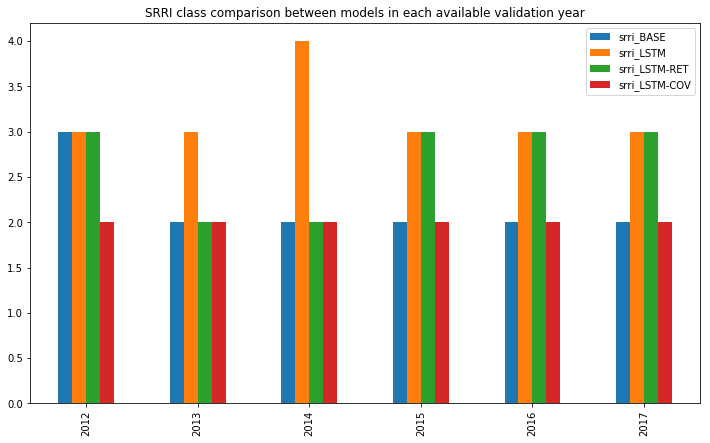

In [96]:
combined_summary[[col for col in combined_summary.columns if 'srri' in col]].plot(kind='bar', figsize=(12,7))
plt.title("SRRI class comparison between models in each available validation year")
plt.show()

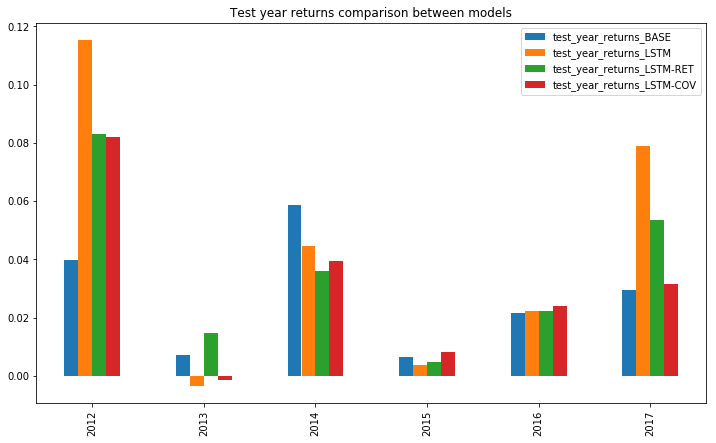

In [97]:
combined_summary[[col for col in combined_summary.columns if 'test_year_returns' in col]].plot(kind='bar', figsize=(12,7))
plt.title("Test year returns comparison between models")
plt.show()

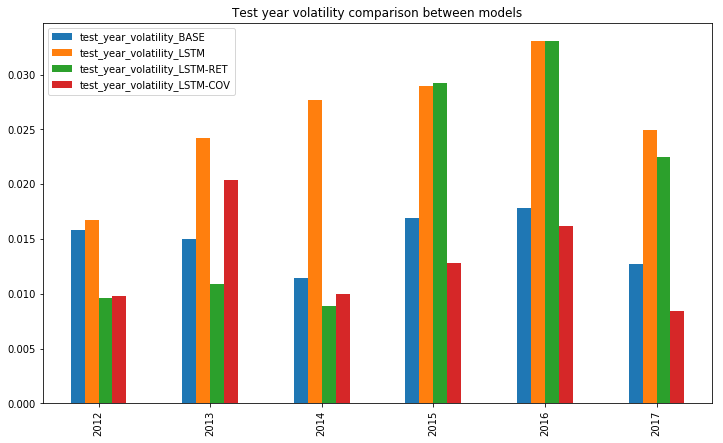

In [98]:
combined_summary[[col for col in combined_summary.columns if 'test_year_volatility' in col]].plot(kind='bar', figsize=(12,7))
plt.title("Test year volatility comparison between models")
plt.show()

**We can see that, on average, LSTM-based portfolio strategies often outperform base portfolio strategy, 
but they are also a little riskier (while still within the limits of SRRI no greater than 4).**

**The only exception to that rule is LSTM-COV hybrid model, which usually achieves slightly better results than base model,
with significantly reduced volatility in all but one test years.**

In [99]:
base = base_results_df.copy()
lstm = lstm_results_df.copy()
lstm.columns = base.columns
hybrid_ret = hybrid_results_df[[col for col in hybrid_results_df.columns if 'LSTM-RET' in col]]
hybrid_ret.columns = base.columns
hybrid_cov = hybrid_results_df[[col for col in hybrid_results_df.columns if 'LSTM-COV' in col]]
hybrid_cov.columns = base.columns
base['model'] = 'BASE'
lstm['model'] = 'LSTM'
hybrid_ret['model'] = 'LSTM-RET'
hybrid_cov['model'] = 'LSTM-COV'
model_results = pd.concat([base, lstm, hybrid_ret, hybrid_cov], axis='index').dropna(axis='index').sort_index()
model_results

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,AP,ARR,ARW,G,OP,ORR,ORW,srri,volatility,test_year_returns,test_year_volatility,model
2010,0.0000e+00,9.7180e-02,0.0000e+00,2.9988e-02,0.0000e+00,8.7283e-01,0.0000e+00,3,0.0255,0.0411,0.0218,BASE
2011,0.0000e+00,7.2626e-02,0.0000e+00,1.3789e-01,0.0000e+00,7.8949e-01,0.0000e+00,3,0.0226,0.0474,0.0173,BASE
2012,4.6715e-03,1.1681e-02,0.0000e+00,5.6168e-01,9.2019e-02,8.1315e-02,2.4863e-01,3,0.0217,0.0832,0.0097,LSTM-RET
2012,1.3137e-12,1.5258e-12,1.5194e-12,4.3154e-01,2.7656e-01,1.7086e-01,1.2104e-01,2,0.0157,0.0819,0.0098,LSTM-COV
2012,5.1780e-03,0.0000e+00,2.1079e-15,1.7168e-01,1.6836e-01,1.9712e-01,4.5766e-01,3,0.0371,0.1152,0.0167,LSTM
2012,0.0000e+00,2.9938e-02,0.0000e+00,1.6353e-01,0.0000e+00,8.0653e-01,0.0000e+00,3,0.0230,0.0398,0.0158,BASE
2013,0.0000e+00,0.0000e+00,0.0000e+00,4.9903e-01,1.3790e-01,1.2685e-01,2.3622e-01,2,0.0199,-0.0013,0.0204,LSTM-COV
2013,0.0000e+00,0.0000e+00,0.0000e+00,3.7674e-01,2.2305e-01,1.6046e-01,2.3974e-01,3,0.0221,-0.0035,0.0242,LSTM
2013,0.0000e+00,0.0000e+00,0.0000e+00,3.9644e-01,9.8262e-02,5.0530e-01,0.0000e+00,2,0.0158,0.0073,0.0150,BASE
2013,0.0000e+00,4.9259e-10,0.0000e+00,7.0281e-01,1.6899e-01,7.0877e-02,5.7324e-02,2,0.0086,0.0148,0.0109,LSTM-RET


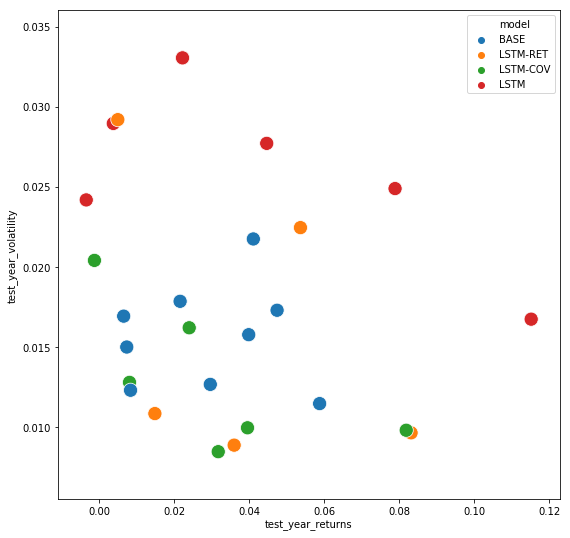

In [100]:
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(ax=ax, data=model_results, x='test_year_returns', y='test_year_volatility', hue='model', s=200)
plt.show()

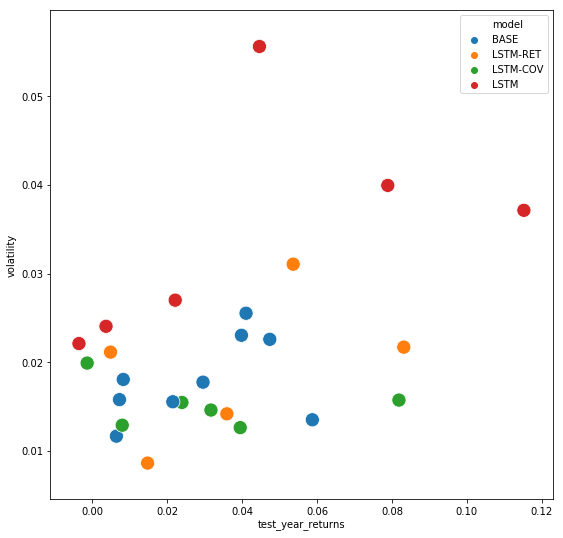

In [101]:
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(ax=ax, data=model_results, x='test_year_returns', y='volatility', hue='model', s=200)
plt.show()

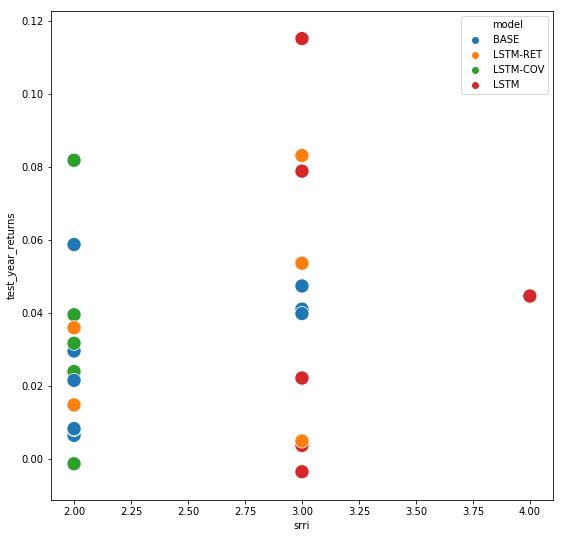

In [108]:
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(ax=ax, data=model_results, x='srri', y='test_year_returns', hue='model', s=200)
plt.show()

## Saving models & data

Targets were saved as soon as generated, other data is relatively fast to compute and there is no need for saving it.

Results are saved only for easier comparison in the future.

In [109]:
for idx, model in enumerate(models):
    torch.save(model.state_dict(), f'data/forecasting/model_{idx}.pt')

In [110]:
combined_results.to_csv('data/forecasting/results_summary.csv')
model_results.to_csv('data/forecasting/model_results.csv')